# TM-G testing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('Data/hourly_data_ff.csv')
time = df['timestamp']
df.drop(columns=['timestamp'], inplace=True)

In [3]:
dfs = np.array_split(df,10)
times = np.array_split(time,10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


The Granger causality test indicates that the only orderbook features that cause the volatility are ask_depth, bid_depth, bid_volume, spread and volume_difference. We thus train the model using only these features.


In [ ]:
from Models.TM_G import TM_G
from Model_eval.TM_eval import evaluate_TM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy

useful_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
useful_cols = useful_features + ['vol']
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols].iloc[5:]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols].iloc[5:]

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate), useful_features)
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = len(useful_features), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[useful_features] = scaler.fit_transform(new_df_train[useful_features])
  model.train_model(df_train, epochs = 2000)
  df_test[useful_features] = scaler.transform(df_test[useful_features])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/TM_G.py:76: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  g_order = F.softplus(self.A.T @ order_book_feats @ self.B, beta = 1)
100%|██████████| 2000/2000 [00:03<00:00, 602.45it/s]


Cross validated interval 3


100%|██████████| 2000/2000 [00:03<00:00, 625.36it/s]


Predicted interval 4


100%|██████████| 2000/2000 [00:03<00:00, 586.73it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:02<00:00, 756.93it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 512.23it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 803.00it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:02<00:00, 697.29it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 631.95it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:04<00:00, 444.65it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 953.96it/s] 


Predicted interval 8


100%|██████████| 2000/2000 [00:02<00:00, 773.13it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:03<00:00, 550.07it/s]


Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


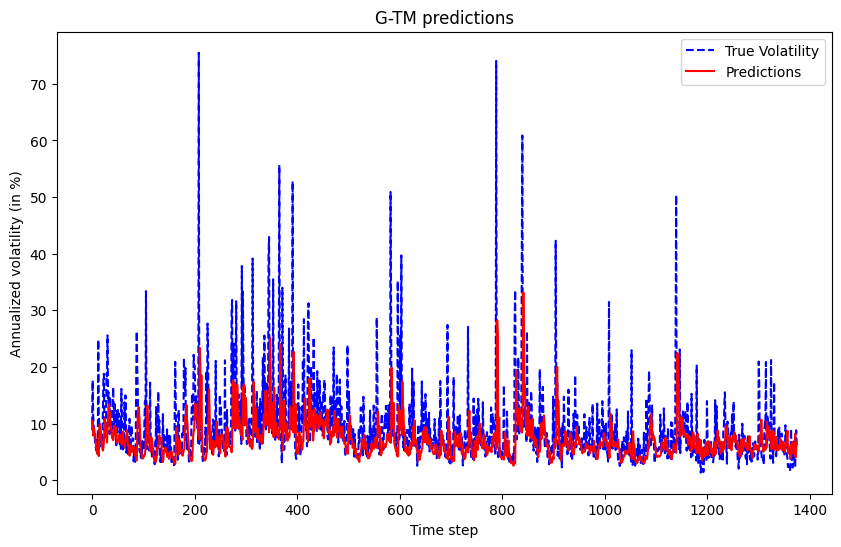

In [7]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0739, MAE: 0.0423
Test RMSE: 0.0907, MAE: 0.0541
Test RMSE: 0.0637, MAE: 0.0374
Test RMSE: 0.0873, MAE: 0.0428
Test RMSE: 0.0531, MAE: 0.0281
Test RMSE: 0.0363, MAE: 0.0243


In [12]:
dfs = np.array_split(df,10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We now check if adding our remaining features lead to improved performance.

In [ ]:
feature_cols = df.columns.difference(['vol'])
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 643.87it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:03<00:00, 626.00it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 658.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 981.36it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:04<00:00, 499.47it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 920.42it/s] 


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 511.02it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 748.46it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 545.31it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:01<00:00, 1021.96it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


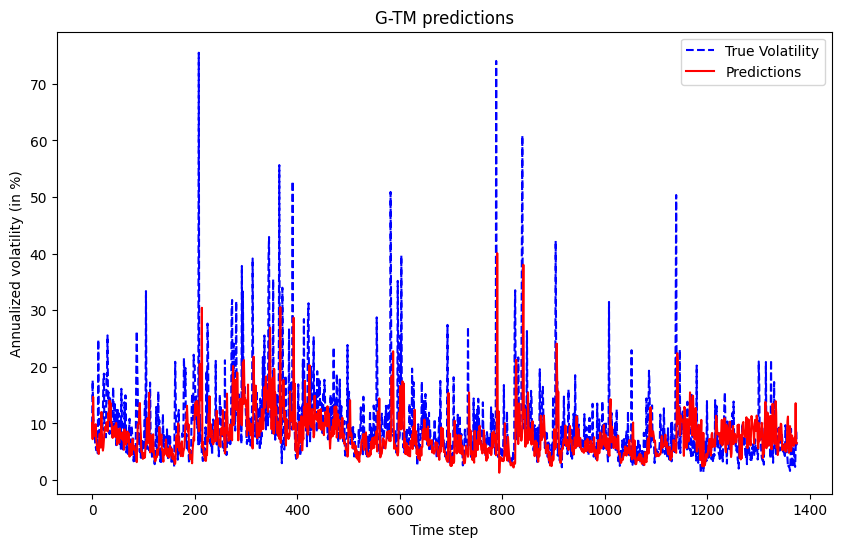

In [15]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0762, MAE: 0.0440
Test RMSE: 0.0873, MAE: 0.0541
Test RMSE: 0.0641, MAE: 0.0383
Test RMSE: 0.0904, MAE: 0.0451
Test RMSE: 0.0532, MAE: 0.0293
Test RMSE: 0.0436, MAE: 0.0330


# Sentiment TM-G testing

The granger causality test indicates that our sentiment time series Granger-causes the volatility up to two lags, so we choose the look back window for the sentiment component to be 2.

In [7]:
sent = pd.read_csv('Data/sentiment.csv')

In [8]:
dfs = np.array_split(df,10)
sents = np.array_split(sent,10)

for i in range(10):
    dfs[i]['sentiment'] = sents[i]['Aggregate sentiment'].values


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
import matplotlib.pyplot as plt
from Models.TM_SG import TM_SG
from Model_eval.TM_eval import evaluate_STM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation_S
import copy
useful_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
useful_cols = useful_features + ['vol', 'sentiment']
predictions = []
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols]

  best_params = cross_validation_S(copy.deepcopy(df_train), copy.deepcopy(df_validate), useful_features)
  print(f'Cross validated interval {i}')

  model = TM_SG(n_features = len(useful_features), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[useful_features] = scaler.fit_transform(new_df_train[useful_features])
  model.train_model(df_train, epochs = 2000)
  df_test[useful_features] = scaler.transform(df_test[useful_features])
  print(f'Predicted interval {i+1}')

  _, _, y_pred = evaluate_STM(model, df_test, plot = False)
  predictions.append(y_pred)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/augustedarracqparies/Documents/Master/Paper ML/Git Code/TMM-for-BTC-volatility-prediction/Models/TM_SG.py:76: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  g_order = F.softplus(self.A.T @ order_book_feats @ self.B)
100%|██████████| 2000/2000 [00:03<00:00, 631.67it/s]


Cross validated interval 3


100%|██████████| 2000/2000 [00:02<00:00, 856.33it/s]


Predicted interval 4


100%|██████████| 2000/2000 [00:02<00:00, 707.15it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:02<00:00, 869.78it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:02<00:00, 711.01it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 894.09it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 653.34it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 896.31it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:02<00:00, 714.44it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 922.14it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 654.72it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:02<00:00, 676.03it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


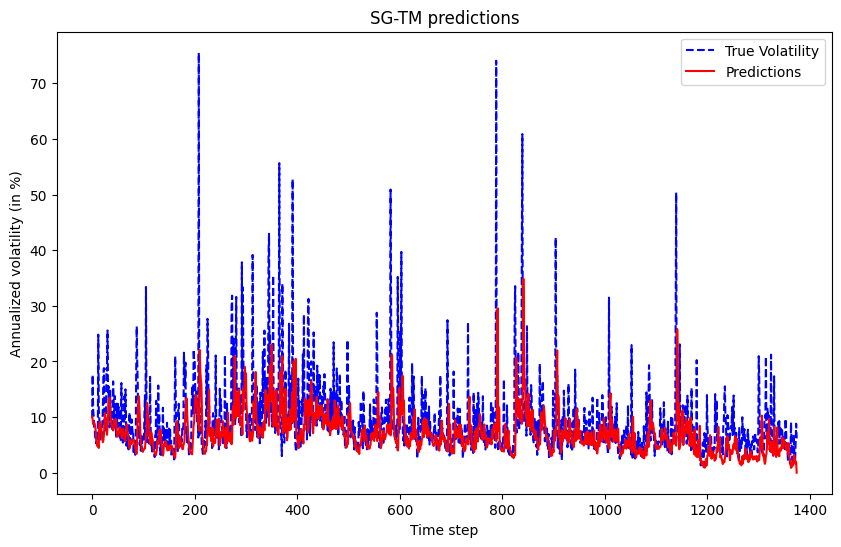

In [87]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('SG-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(4,10):
  start = int(np.sum([len(dfs[j]) for j in range(4, i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0742, MAE: 0.0427
Test RMSE: 0.0908, MAE: 0.0554
Test RMSE: 0.0633, MAE: 0.0371
Test RMSE: 0.0881, MAE: 0.0437
Test RMSE: 0.0534, MAE: 0.0294
Test RMSE: 0.0464, MAE: 0.0327


# LSTMX

(522, 6)
(261, 6)
(261, 6)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cross validated interval 3
(783, 6)
Predicted interval 4
(522, 6)
(261, 6)
(260, 6)
Cross validated interval 4
(783, 6)
Predicted interval 5
(522, 6)
(260, 6)
(260, 6)
Cross validated interval 5
(782, 6)
Predicted interval 6
(522, 6)
(260, 6)
(260, 6)
Cross validated interval 6
(782, 6)
Predicted interval 7
(521, 6)
(260, 6)
(260, 6)
Cross validated interval 7
(781, 6)
Predicted interval 8
(520, 6)
(260, 6)
(260, 6)
Cross validated interval 8
(780, 6)
Predicted interval 9
RMSE on each interval:  [6.7816014, 8.284238, 5.551058, 7.208822, 5.38882, 5.2413087]
MAE on each interval: [3.5175238, 6.725178, 3.5572486, 3.6278117, 4.2395844, 4.733641]
Size of the merged dataset: (1471, 11)


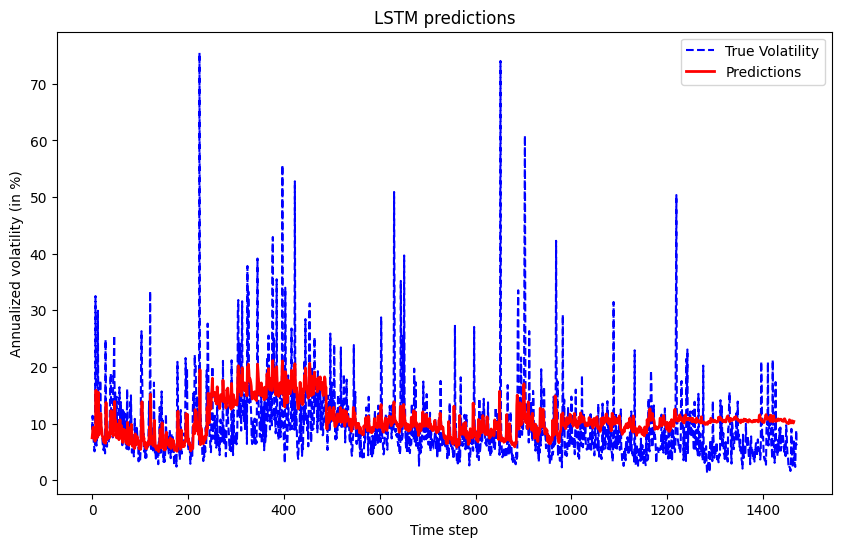

In [ ]:
from Models.LSTM import *
from Model_eval.LSTM_eval import *
from Models.CVal_LSTM import *
import copy
predictions = []
rmse_list = []
mae_list = []
useful_features =  
feature_cols = useful_features
useful_cols = feature_cols + ['vol']
for i in range(3, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)[useful_cols]
  df_validate = copy.deepcopy(dfs[i])[useful_cols]
  df_test =copy.deepcopy(dfs[i+1])[useful_cols]


  X_train_vol, X_train_orderbook, y_train = prepare_data_from_metrics(
    df_train,
    orderbook_timesteps=15,
    future_horizon=1
)
  X_val_vol, X_val_orderbook, y_val = prepare_data_from_metrics(
    df_validate,
    orderbook_timesteps=15,
    future_horizon=1
)


  X_test_vol, X_test_orderbook, y_test = prepare_data_from_metrics(
    df_test,
    orderbook_timesteps=15,
    future_horizon=1
)

  model, best_params, best_rmse = grid_search_LSTM(
    param_grid,
    X_train_vol, X_train_orderbook, y_train,
    X_val_vol, X_val_orderbook, y_val,
    epochs=5,
    batch_size=32
)



  print(f'Cross validated interval {i}')


  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()

  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])

  X_volatility, X_orderbook, y = prepare_data_from_metrics(
    new_df_train,
    orderbook_timesteps=15,
    future_horizon=1
)


  model.train_model(X_volatility, X_orderbook,y)

  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  rmse, mae, _, y_pred = evaluate_model_mse(model, X_test_vol, X_test_orderbook, y_test)
  predictions.append(y_pred)
  rmse_list.append(rmse)
  mae_list.append(mae)



final_pred = [pred for interval in predictions for pred in interval]


print('RMSE on each interval: ',rmse_list)
print('MAE on each interval:', mae_list)
timesteps_lost = 15
dfs_trimmed = [dfs[i][timesteps_lost:].reset_index(drop=True) for i in range(10)]
merged = pd.concat(dfs_trimmed[4:10], ignore_index=True)
print(f"Size of the merged dataset: {merged.shape}")




plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red', linewidth = 2)
plt.title('LSTM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()



# LSTM x GARCH


In [ ]:
from Model_eval.LSTM_eval import evaluate_model_mse_garch_with_alpha
from Models.LSTM_GARCH import *
from Models.GARCH import *
from Models.CVal_LSTM import *
import copy
from tqdm import tqdm
import pandas as pd
import numpy as np

df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv'
)
df = pd.read_csv(
    'Data/hourly_data_ff.csv'
)
feature_cols = df.columns.difference(["vol","timestamp"])
results_df, _ = test_garch(df_returns, df, plot = False)
df['garch_vol'] = np.nan
df.loc[df.index[:len(results_df)], 'garch_vol'] = results_df["PredictedGarch"].values
predictions = []
rmse_list = []
mae_list = []
dfs = np.array_split(df, 10)



for i in tqdm(range(3, 8)):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])


  X_train_vol, X_train_orderbook, X_train_garch, y_train = prepare_data_from_metrics_garch(
    df_train,
    orderbook_timesteps=30,
    future_horizon=1
  )
  X_val_vol, X_val_orderbook,X_val_garch, y_val = prepare_data_from_metrics_garch(
    df_validate,
    orderbook_timesteps=30,
    future_horizon=1
  )
  


  X_test_vol, X_test_orderbook, X_test_garch, y_test = prepare_data_from_metrics_garch(
    df_test,
    orderbook_timesteps=30,
    future_horizon=1
  ) 
  print('Data prepared')

  print('Starting CV')
  model, best_params, best_rmse = grid_search_LSTM(
    param_grid,
    X_train_vol, X_train_orderbook, X_train_garch, y_train,
    X_val_vol, X_val_orderbook,X_val_garch, y_val,
    batch_size=32
  )



  print(f'Cross validated interval {i}')


  
  
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()

  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])

  X_volatility, X_orderbook, X_garch, y = prepare_data_from_metrics_garch(
    new_df_train,
    orderbook_timesteps=30,
    future_horizon=1
  )
  


  model.train_model(X_volatility, X_orderbook, X_garch, y)
  

  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  rmse, mae, y_true, y_pred, alphas = evaluate_model_mse_garch_with_alpha(
    model, X_test_vol, X_test_orderbook, X_test_garch, y_test
  )

  plt.figure(figsize=(10, 6))
  plt.plot(alphas, label="Alpha (weight on GARCH)", color='green')
  plt.title("Dynamic Alpha Over Time")
  plt.xlabel("Time Step")
  plt.ylabel("Alpha Value")
  plt.ylim(0, 1)
  plt.legend()
  plt.grid(True)
  plt.show()
  predictions.append(y_pred)
  rmse_list.append(rmse)
  mae_list.append(mae)



final_pred = [pred for interval in predictions for pred in interval]


print('RMSE on each interval: ',rmse_list)
print('MAE on each interval:', mae_list)
dfs_trimmed =  [df.iloc[79:].reset_index(drop=True) for df in dfs]
merged = pd.concat(dfs_trimmed[4:9], ignore_index=True)




plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('LSTM-GARCH predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

Starting lookback window optimization...
Starting volatility prediction...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/5 [00:00<?, ?it/s]

# HAR models

[Block 1] Windows taken into account : [1, 2, 3, 25]
[Block 2] Windows taken into account : [1, 2, 28]
[Block 3] Windows taken into account : [1, 2, 7, 15, 17, 27, 29]
[Block 4] Windows taken into account : [1, 2, 4, 5, 9, 16, 17, 21, 27]
[Block 5] Windows taken into account : [1, 2, 8, 16, 17, 21, 27]
[Block 6] Windows taken into account : [1, 21, 27]


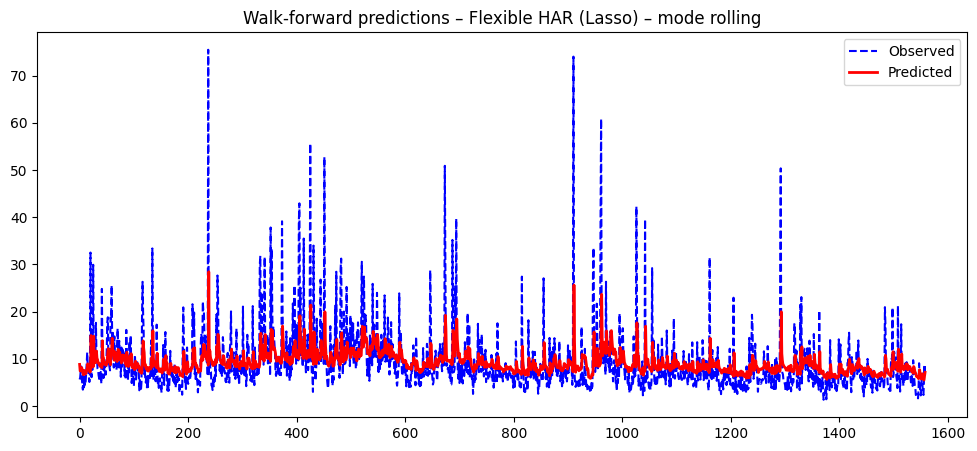

   bloc       MAE      RMSE                     Windows used
0     1  0.036896  0.065479                    [1, 2, 3, 25]
1     2  0.045052  0.076367                       [1, 2, 28]
2     3  0.034671  0.054865        [1, 2, 7, 15, 17, 27, 29]
3     4  0.037003  0.071565  [1, 2, 4, 5, 9, 16, 17, 21, 27]
4     5  0.032745  0.051158        [1, 2, 8, 16, 17, 21, 27]
5     6  0.027693  0.036663                      [1, 21, 27]
[Block 1] Windows taken into account : [1, 6, 24]
[Block 2] Windows taken into account : [1, 6, 24]
[Block 3] Windows taken into account : [1, 6, 24]
[Block 4] Windows taken into account : [1, 6, 24]
[Block 5] Windows taken into account : [1, 6, 24]
[Block 6] Windows taken into account : [1, 6, 24]


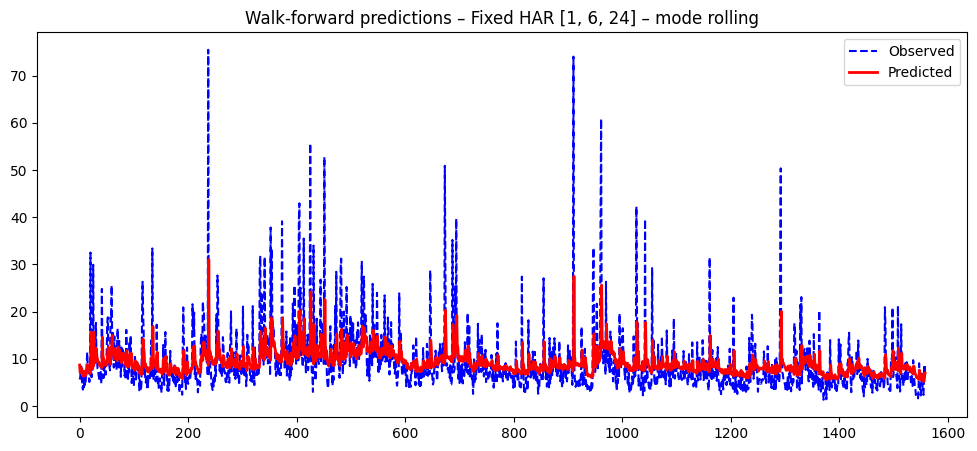

   bloc       MAE      RMSE Windows used
0     1  0.037051  0.065846   [1, 6, 24]
1     2  0.045691  0.075577   [1, 6, 24]
2     3  0.034831  0.055204   [1, 6, 24]
3     4  0.037139  0.070818   [1, 6, 24]
4     5  0.032617  0.050933   [1, 6, 24]
5     6  0.027243  0.036528   [1, 6, 24]


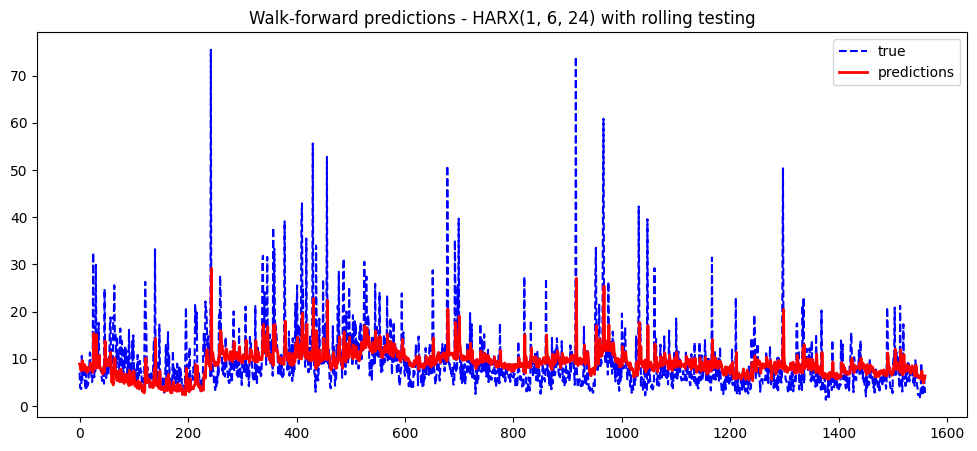

   window       MAE      RMSE Used Windows
0       1  0.042364  0.073344   [1, 6, 24]
1       2  0.047410  0.076988   [1, 6, 24]
2       3  0.037082  0.055861   [1, 6, 24]
3       4  0.041165  0.071500   [1, 6, 24]
4       5  0.034186  0.051411   [1, 6, 24]
5       6  0.027844  0.036775   [1, 6, 24]


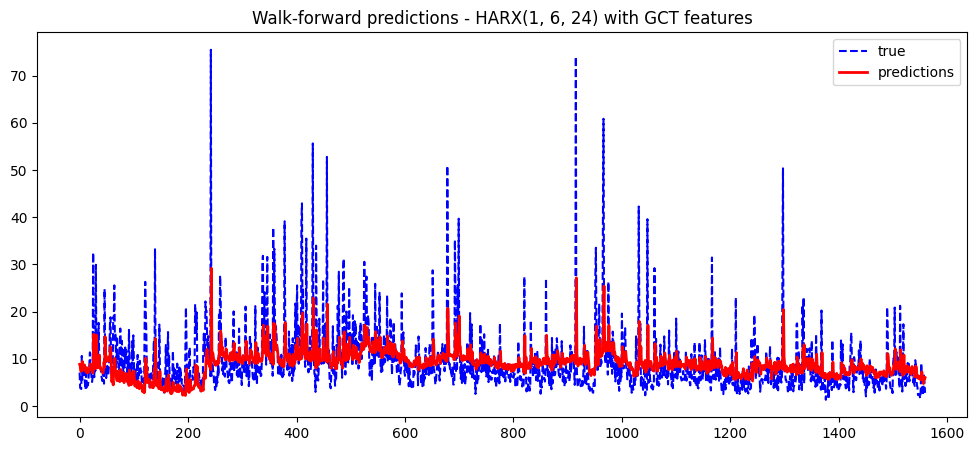

   window       MAE      RMSE Used Windows
0       1  0.042621  0.073393   [1, 6, 24]
1       2  0.046973  0.076964   [1, 6, 24]
2       3  0.036298  0.055505   [1, 6, 24]
3       4  0.040807  0.071355   [1, 6, 24]
4       5  0.033928  0.051328   [1, 6, 24]
5       6  0.027263  0.036408   [1, 6, 24]


In [2]:
from Models.HAR import *
from Models.HARX import *
df = pd.read_csv('Data/hourly_data_ff.csv')
Y = df['vol'].values

sim1 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=True)
sim1.add_rolling_features()
sim1.run_simulation()
sim1.plot_predictions()
sim1.summary()

sim2 = HARSimulator(df=df, Y=Y, shift=1, mode='rolling', use_lasso=False, fixed_windows=[1, 6, 24])
sim2.add_rolling_features()
sim2.run_simulation()
sim2.plot_predictions()
sim2.summary()

sim3 = HARXSimulator(df=df, Y=Y, shift=1, mode='rolling')
sim3.add_rolling_features()
sim3.run_simulation()
sim3.plot_predictions()
sim3.summary()

sim4 = HARXSimulator(df=df, Y=Y, shift=1, mode='rolling', GCT = True)
sim4.add_rolling_features()
sim4.run_simulation()
sim4.plot_predictions()
sim4.summary()


# GARCH

In [ ]:
import pandas as pd
df_returns = pd.read_csv(
    'Data/hourly_data_ff_with_returns.csv',
    parse_dates=['timestamp']
)
df_vol = pd.read_csv(
    'Data/hourly_data_ff.csv',
    parse_dates=['timestamp']
)

Starting lookback window optimization...
Starting volatility prediction...

Mean RMSE for each of the 10 intervals:
Interval 1: 0.06173
Interval 2: 0.06493
Interval 3: 0.05906
Interval 4: 0.04804
Interval 5: 0.06029
Interval 6: 0.06955
Interval 7: 0.05147
Interval 8: 0.05504
Interval 9: 0.03855
Interval 10: 0.03826


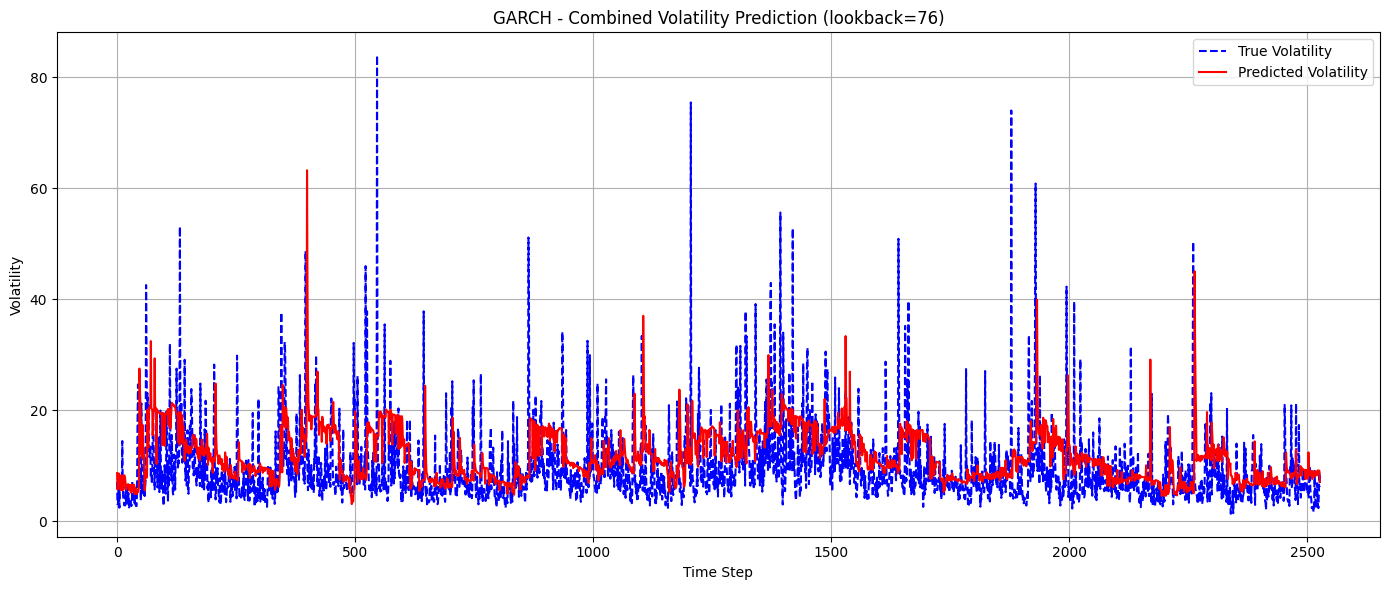

In [3]:
from Models.GARCH import test_garch
results_df, mean_rmse_intervals = test_garch(df_returns, df_vol)

# XGBoost



[Window 1] Training on intervals 0-2, validating on 3, testing on 4

[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.073505  0.051556
1       2  0.078806  0.051696
2       3  0.076710  0.057232
3       4  0.075383  0.046462
4       5  0.055777  0.035473
5       6  0.080752  0.070369


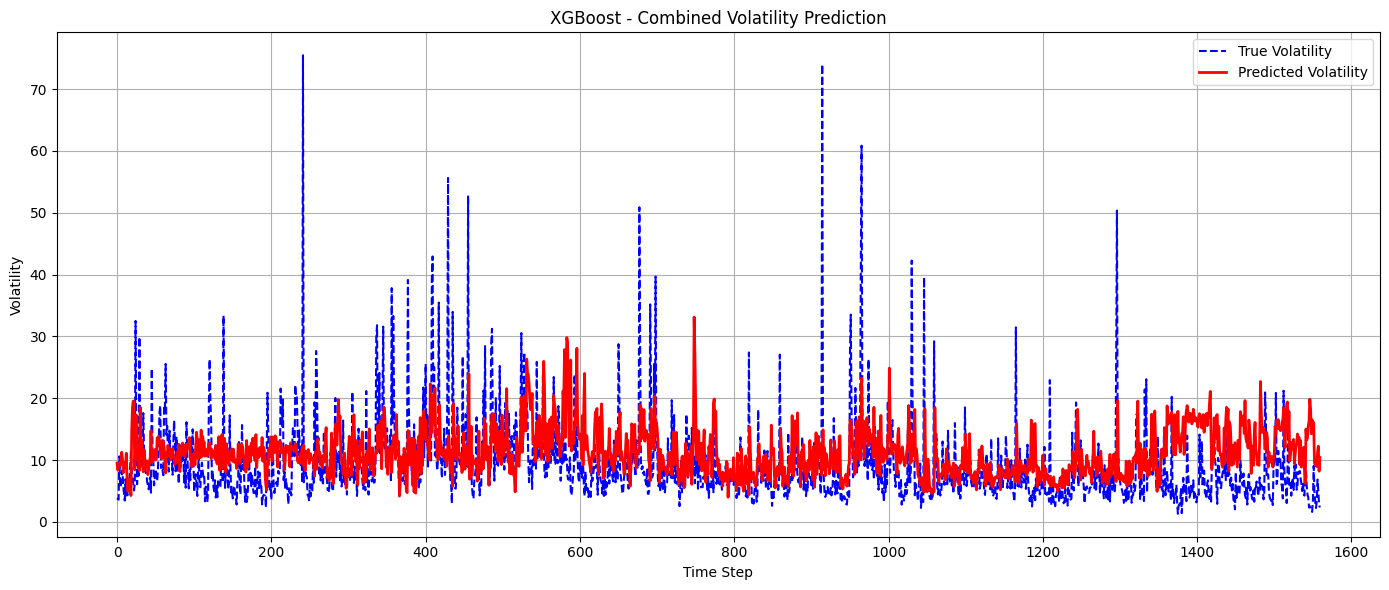

,Window,RMSE,MAE
0,1,0.073505,0.051556
1,2,0.078806,0.051696
2,3,0.076710,0.057232
3,4,0.075383,0.046462
4,5,0.055777,0.035473
5,6,0.080752,0.070369


In [3]:
from Models.XGBoost import *

df = pd.read_csv('Data/hourly_data_ff.csv')
df = df.drop(columns=['timestamp']) 


test_xgboost(df)

# XGBoost with GCT features



[Window 1] Training on intervals 0-2, validating on 3, testing on 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.071607  0.048816
1       2  0.077835  0.047539
2       3  0.063841  0.045988
3       4  0.078319  0.046841
4       5  0.054287  0.036399
5       6  0.081595  0.072305


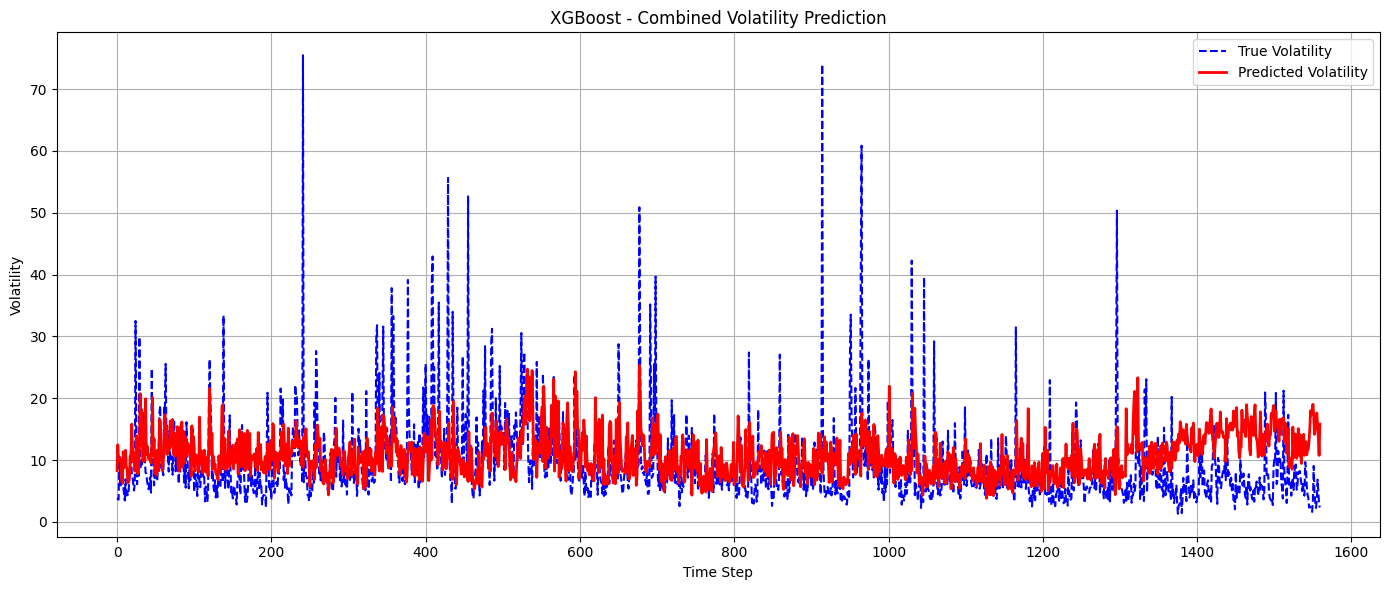

,Window,RMSE,MAE
0,1,0.071607,0.048816
1,2,0.077835,0.047539
2,3,0.063841,0.045988
3,4,0.078319,0.046841
4,5,0.054287,0.036399
5,6,0.081595,0.072305


In [5]:
from Models.XGBoost import *
import numpy as np

df = pd.read_csv('DATA/hourly_data_ff.csv')

granger_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
df = df[granger_features + ['vol']]

test_xgboost(df)

# XGBoost exclusively with sentiment


[Window 1] Training on intervals 0-2, validating on 3, testing on 4

[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 5] Training on intervals 4-6, validating on 7, testing on 8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.072903  0.043224
1       2  0.075822  0.048674
2       3  0.070392  0.050352
3       4  0.077863  0.049064
4       5  0.053225  0.033976
5       6  0.036767  0.025961


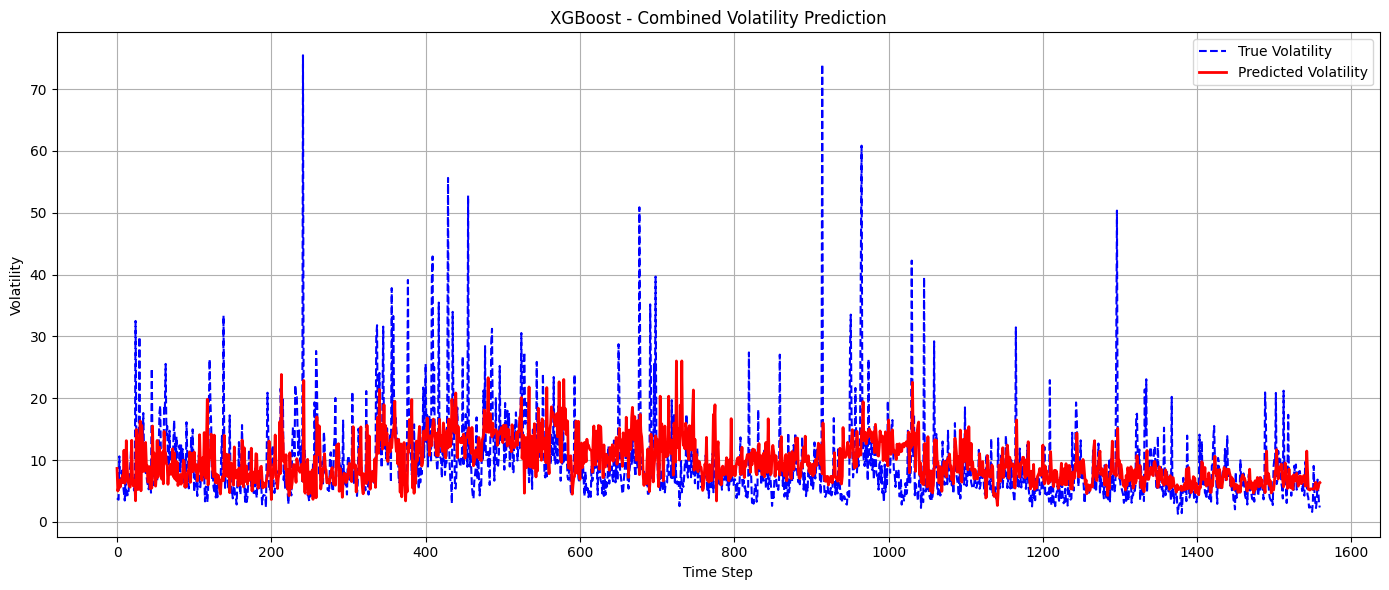

,Window,RMSE,MAE
0,1,0.072903,0.043224
1,2,0.075822,0.048674
2,3,0.070392,0.050352
3,4,0.077863,0.049064
4,5,0.053225,0.033976
5,6,0.036767,0.025961


In [11]:
from Models.XGBoost import *

df = pd.read_csv('DATA/hourly_data_ff.csv')
sent = pd.read_csv('DATA/sentiment.csv')

empty_features = []
df = df[empty_features + ['vol']]

df = pd.concat([df, sent[['Aggregate sentiment', 'fng_feature']]], axis=1)

test_xgboost(df)

# XGBoost with GCT features \& sentiment


[Window 1] Training on intervals 0-2, validating on 3, testing on 4

[Window 2] Training on intervals 1-3, validating on 4, testing on 5

[Window 3] Training on intervals 2-4, validating on 5, testing on 6

[Window 4] Training on intervals 3-5, validating on 6, testing on 7

[Window 5] Training on intervals 4-6, validating on 7, testing on 8

[Window 6] Training on intervals 5-7, validating on 8, testing on 9

[Summary]
   Window      RMSE       MAE
0       1  0.066460  0.040126
1       2  0.080055  0.050090
2       3  0.066451  0.052185
3       4  0.078724  0.049348
4       5  0.053535  0.032004
5       6  0.071297  0.064505


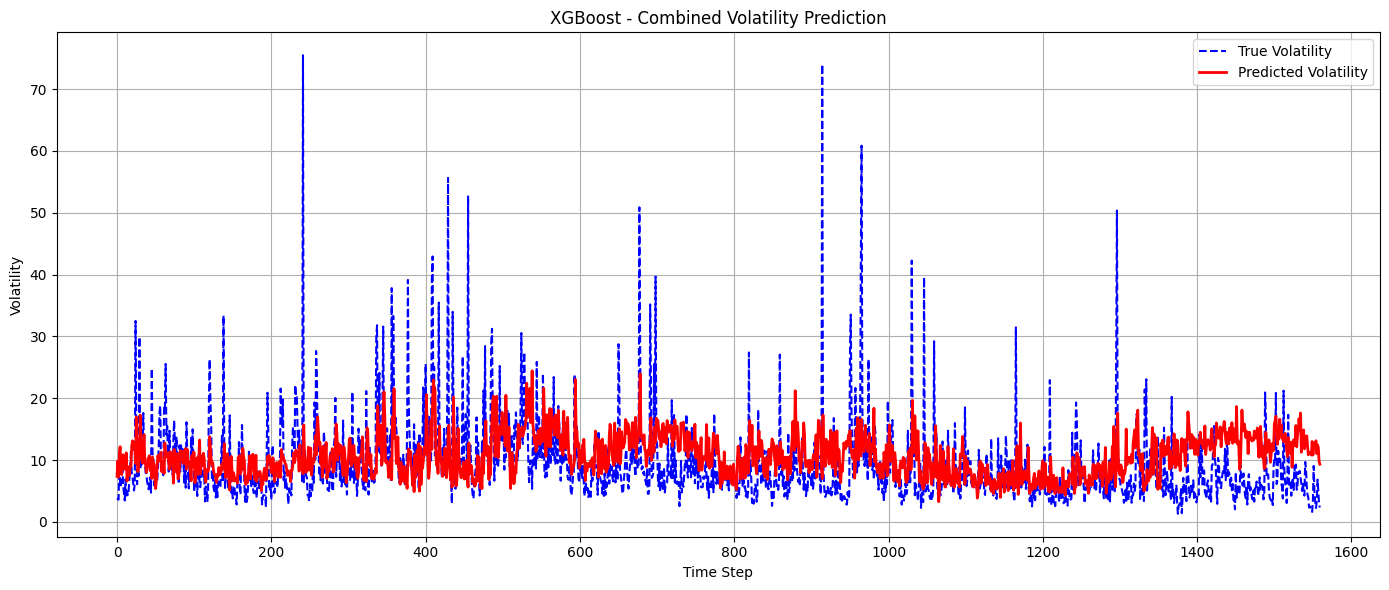

,Window,RMSE,MAE
0,1,0.066460,0.040126
1,2,0.080055,0.050090
2,3,0.066451,0.052185
3,4,0.078724,0.049348
4,5,0.053535,0.032004
5,6,0.071297,0.064505


In [13]:
from Models.XGBoost import *

df = pd.read_csv('DATA/hourly_data_ff.csv')
sent = pd.read_csv('DATA/sentiment.csv')

granger_features = ['ask_depth', 'bid_depth', 'bid_volume', 'spread', 'volume_difference']
df = df[granger_features + ['vol']]

df = pd.concat([df, sent[['Aggregate sentiment', 'fng_feature']]], axis = 1)

test_xgboost(df)